MNIST手写数据集是深度学习中的“Hello world”，是深度学习中最容易上手的一个项目。MNIST的任务是让计算机识别手写数据集。该数据集包含70,000张手写数字图像: 60,000张用于训练模型，10,000张用于测试。图像是灰度的，分辨率也仅有28x28像素，因而程序的预处理和运行都很方便。

在这个网络当中，我们将使用两个卷积层，一个池化层和两个全连接层，这些层将28x28的像素块压缩成9维的向量，并与正确的数字预测结果做比较。一般而言，深度学习的框架由四部分组成：网络结构、损失函数、数据集和优化器。在本次的介绍中，我们会把这四个模块分别解耦进行讲解。

首先我们先来导入相关库,运行本程序需要拥有pytorch和anaconda3的环境

In [48]:
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
import numpy as np
import gzip
import os
import matplotlib.pyplot as plt

In [47]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
lr = 0.01
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

现在我们来开始尝试导入数据集，这一步的主要目的是将深度学习的图像转换成pytorch能够看懂的数据格式。我们先来创建一个dataset类，并用pytorch的`dataloader`方法加载mnist数据集。在下述的类中，有三个魔法方法。`__init__(self, ...) `方法是类的构造函数，在创建类的新实例时被调用。对于数据集类，`__init__ `方法通常用于初始化或加载数据集。例如，在处理MNIST数据集时，我们可以在这里加载数据集文件，进行预处理（如标准化、转换为Tensor等），并设置任何需要的参数。这个方法只在类的实例被创建时执行一次。`__getitem__(self, index) `方法是为了使实例能够像列表一样通过索引来访问。在数据集类中，`__getitem__ `负责返回与给定索引相对应的数据样本（和标签）。例如，在MNIST数据集中，这个方法将返回第index个图像及其对应的标签。这是实现数据加载的核心，因为它允许DataLoader在训练时逐个或批量地获取数据。而`__len__(self) `方法用于返回可迭代对象中样本的总数。在PyTorch中，DataLoader 使用这个方法来确定每个epoch需要迭代多少次以遍历整个数据集。这对于批处理和计算epoch很重要。

In [38]:
"""
    data_folder: 文件目录
    data_name： 数据文件名
    label_name：标签数据文件名
"""
    
class DatasetProcessing():
    def __init__(self, folder, data_name, label_name, transform = None):
        (train_set, train_labels) = self._load_data(folder, data_name, label_name)
        self.train_set = train_set
        self.train_labels = train_labels
        self.transform = transform

    def _load_data(self, data_folder, data_name, label_name):
        with gzip.open(os.path.join(data_folder,label_name), 'rb') as lbpath: # rb表示的是读取二进制数据,lbpath指的就是标签的存放路径。
            y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

        with gzip.open(os.path.join(data_folder,data_name), 'rb') as imgpath:
            x_train = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)
        return (x_train, y_train)
    
    def __getitem__(self, index):

        img, target = self.train_set[index], int(self.train_labels[index])
        if self.transform is not None:
            img = self.transform(img)
        plt.imshow(img, cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(target))
        return img, target
    
    def __len__(self):
        return len(self.train_set)

train_dataset = DatasetProcessing('./data/',"train-images-idx3-ubyte.gz","train-labels-idx1-ubyte.gz")
test_dataset = DatasetProcessing('./data/',"t10k-images-idx3-ubyte.gz","t10k-labels-idx1-ubyte.gz")

In [33]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size_train, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size_test, shuffle = False)

我们来看下数据集具体的形状吧！

(array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,  47, 231, 196,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0, 182, 253, 150,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0, 123, 247, 222,  30,   0,   0,   0,   0,   0,
           0

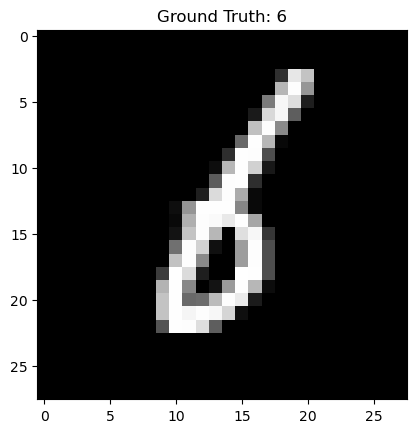

In [45]:
train_dataset[256]

目前我们已经成功的加载好了数据集。我们将正式开始构建深度学习的神经网络！

In [49]:
class Conv3x3(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Conv3x3, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, bias=True), 
            nn.LeakyReLU(0.1, inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.c1 = Conv3x3(1,8)
        self.c2 = Conv3x3(8,16)
        self.c3 = Conv3x3(16,4)
        self.rl1 = nn.Linear(100,10)
        

    def forward(self,x):
        x = self.c1(x) # 26x26x8
        x = self.c2(x) # 24x24x16
        x = F.adaptive_avg_pool2d(x,2) # 12x12x16
        x = self.c3(x)# 10x10x4
        x = F.adaptive_avg_pool2d(x,2) #5x5x4
        x = x.view(-1,100)
        x = self.rl1(100,10)
        return F.log_softmax(x)

现在我们来初始化网络和优化器。